In [4]:
import numpy as np
from typing import Optional, Tuple, List
from itertools import combinations

class THAIDNode:
    """Node in a THAID tree."""
    __slots__ = ('prediction', 'score', 'n_samples', 'class_counts',
                 'split_feature_idx', 'split_value', 'split_categories',
                 'is_numeric', 'left', 'right', 'is_leaf')

    def __init__(self):
        self.prediction = -1
        self.score = 0.0  # Stores theta (accuracy) or delta depending on context
        self.n_samples = 0
        self.class_counts = None
        self.split_feature_idx = -1
        self.split_value = None
        self.split_categories = None
        self.is_numeric = False
        self.left = None
        self.right = None
        self.is_leaf = True

class THAID:
    """
    THAID (Theta Automatic Interaction Detection) classifier.

    Parameters
    ----------
    criterion : {'theta', 'delta'}, default='theta'
        The splitting criterion to use.
        - 'theta': Maximizes the sum of modal frequencies (classification accuracy).
        - 'delta': Maximizes the distributional difference between child nodes.
    min_samples_split : int, default=20
        Minimum samples required to split a node
    min_samples_leaf : int, default=1
        Minimum samples required in a leaf
    max_depth : int, optional
        Maximum tree depth
    max_categories : int, default=10
        Max categories for exhaustive search. If categories > max_categories,
        a heuristic search (sorting by majority class probability) is used.
    """

    def __init__(
        self,
        criterion: str = 'theta',
        min_samples_split: int = 20,
        min_samples_leaf: int = 1,
        max_depth: Optional[int] = None,
        max_categories: int = 10
    ):
        if criterion not in ('theta', 'delta'):
            raise ValueError("Criterion must be 'theta' or 'delta'")

        self.criterion = criterion
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.max_categories = max_categories

        self.root_ = None
        self.n_features_ = 0
        self.n_classes_ = 0
        self.classes_ = None
        self.feature_types_ = None  # 0=numeric, 1=categorical
        self.feature_names_ = None

        self._X = None
        self._y = None
        self._sorted_indices = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        """Fit the THAID tree."""
        X, y = self._validate_input(X, y)

        self.classes_, y_encoded = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)
        self.n_features_ = X.shape[1]

        self._detect_feature_types(X)
        self._X = X
        self._y = y_encoded
        self._presort_numeric_features()

        indices = np.arange(len(y))
        self.root_ = self._build_tree(indices, depth=0)

        return self

    def _validate_input(self, X, y):
        """Convert inputs to numpy arrays."""
        if hasattr(X, 'values'):
            self.feature_names_ = list(X.columns)
            X = X.values
        else:
            X = np.asarray(X)
            self.feature_names_ = [f"X{i}" for i in range(X.shape[1])]

        y = y.values if hasattr(y, 'values') else np.asarray(y)

        if X.shape[0] != y.shape[0]:
            raise ValueError(f"Shape mismatch: X has {X.shape[0]} samples, y has {y.shape[0]}")

        # Check for NaN/Inf only in numeric columns
        for i in range(X.shape[1]):
            col = X[:, i]
            if np.issubdtype(col.dtype, np.number):
                if np.any(np.isnan(col)) or np.any(np.isinf(col)):
                    raise ValueError(f"Column {i} contains NaN or Inf")

        return X, y

    def _detect_feature_types(self, X):
        """Detect numeric (0) or categorical (1) features."""
        self.feature_types_ = np.zeros(self.n_features_, dtype=np.int8)

        for i in range(self.n_features_):
            col = X[:, i]
            if not np.issubdtype(col.dtype, np.number):
                self.feature_types_[i] = 1
                continue

            unique_vals = np.unique(col)
            if len(unique_vals) <= 10 and np.allclose(col, np.round(col)):
                self.feature_types_[i] = 1

    def _presort_numeric_features(self):
        """Pre-sort indices for numeric features."""
        self._sorted_indices = []
        for i in range(self.n_features_):
            if self.feature_types_[i] == 0:
                self._sorted_indices.append(np.argsort(self._X[:, i]))
            else:
                self._sorted_indices.append(None)

    def _calculate_split_score(self, left_counts, right_counts, n_total):
        """Calculate the score for a split based on the selected criterion."""
        if self.criterion == 'theta':
            # Theta: Maximize accuracy (modal frequency)
            return (np.max(left_counts) + np.max(right_counts)) / n_total

        elif self.criterion == 'delta':
            # Delta: Maximize distributional difference
            n_left = np.sum(left_counts)
            n_right = np.sum(right_counts)

            if n_left == 0 or n_right == 0:
                return 0.0

            p_left = left_counts / n_left
            p_right = right_counts / n_right

            # L1 distance (Sum of absolute differences)
            return np.sum(np.abs(p_left - p_right))

        return 0.0

    def _build_tree(self, indices, depth):
        """Build tree recursively."""
        node = THAIDNode()
        node.n_samples = len(indices)

        y_subset = self._y[indices]
        node.class_counts = np.bincount(y_subset, minlength=self.n_classes_)

        node.prediction = np.argmax(node.class_counts)
        # Display score is always accuracy (theta) for readability
        node.score = node.class_counts[node.prediction] / node.n_samples

        if self._should_stop(node, depth):
            return node

        best_split = self._find_best_split(indices)

        if best_split is None:
            return node

        feature_idx, split_info, _, left_idx, right_idx = best_split

        if len(left_idx) < self.min_samples_leaf or len(right_idx) < self.min_samples_leaf:
            return node

        node.is_leaf = False
        node.split_feature_idx = feature_idx

        if self.feature_types_[feature_idx] == 0:
            node.is_numeric = True
            node.split_value = split_info
        else:
            node.is_numeric = False
            node.split_categories = split_info

        node.left = self._build_tree(left_idx, depth + 1)
        node.right = self._build_tree(right_idx, depth + 1)

        return node

    def _should_stop(self, node, depth):
        """Check stopping conditions."""
        if np.count_nonzero(node.class_counts) <= 1:
            return True
        if node.n_samples < self.min_samples_split:
            return True
        if self.max_depth is not None and depth >= self.max_depth:
            return True
        return False

    def _find_best_split(self, indices):
        """Find best split across all features."""
        best_score = -1.0
        best_result = None

        for feature_idx in range(self.n_features_):
            if self.feature_types_[feature_idx] == 0:
                result = self._find_numeric_split(indices, feature_idx)
            else:
                result = self._find_categorical_split(indices, feature_idx)

            if result is not None and result[1] > best_score:
                best_score = result[1]
                best_result = (feature_idx,) + result

        return best_result

    def _find_numeric_split(self, indices, feature_idx):
        """Find best numeric split."""
        sorted_full = self._sorted_indices[feature_idx]
        mask = np.isin(sorted_full, indices, assume_unique=True)
        relevant = sorted_full[mask]

        if len(relevant) < 2:
            return None

        X_sorted = self._X[relevant, feature_idx]
        y_sorted = self._y[relevant]
        n_total = len(relevant)

        change_indices = np.where(X_sorted[:-1] != X_sorted[1:])[0]
        if len(change_indices) == 0:
            return None

        right_counts = np.bincount(y_sorted, minlength=self.n_classes_)
        left_counts = np.zeros(self.n_classes_, dtype=np.int64)

        best_score = -1.0
        best_split_val = None
        best_split_idx = None

        current_idx = 0
        for split_idx in change_indices:
            for i in range(current_idx, split_idx + 1):
                cls = y_sorted[i]
                left_counts[cls] += 1
                right_counts[cls] -= 1

            current_idx = split_idx + 1
            score = self._calculate_split_score(left_counts, right_counts, n_total)

            if score > best_score:
                best_score = score
                best_split_idx = split_idx
                best_split_val = (X_sorted[split_idx] + X_sorted[split_idx + 1]) / 2.0

        if best_split_val is None:
            return None

        left_mask = X_sorted <= X_sorted[best_split_idx]
        left_indices = indices[np.isin(indices, relevant[left_mask])]
        right_indices = indices[np.isin(indices, relevant[~left_mask])]

        return best_split_val, best_score, left_indices, right_indices

    def _find_categorical_split(self, indices, feature_idx):
        """Find best categorical split using Exhaustive OR Heuristic search."""
        X_col = self._X[indices, feature_idx]
        unique_vals = np.unique(X_col)

        if len(unique_vals) < 2:
            return None

        # Decision: Exhaustive vs Heuristic
        if len(unique_vals) <= self.max_categories:
            return self._exhaustive_categorical(indices, feature_idx, unique_vals)
        else:
            return self._heuristic_categorical(indices, feature_idx, unique_vals)

    def _exhaustive_categorical(self, indices, feature_idx, unique_vals):
        """Exhaustive search over category subsets O(2^C)."""
        X_col = self._X[indices, feature_idx]
        y_subset = self._y[indices]
        n_total = len(indices)

        best_score = -1.0
        best_categories = None

        max_size = (len(unique_vals) // 2) + 1

        for size in range(1, max_size):
            for combo in combinations(unique_vals, size):
                mask = np.isin(X_col, combo)

                if not np.any(mask) or np.all(mask):
                    continue

                y_left = y_subset[mask]
                y_right = y_subset[~mask]

                counts_left = np.bincount(y_left, minlength=self.n_classes_)
                counts_right = np.bincount(y_right, minlength=self.n_classes_)

                score = self._calculate_split_score(counts_left, counts_right, n_total)

                if score > best_score:
                    best_score = score
                    best_categories = set(combo)

        if best_categories is None:
            return None

        # Create final mask for indices split
        final_mask = np.isin(X_col, list(best_categories))
        return best_categories, best_score, indices[final_mask], indices[~final_mask]

    def _heuristic_categorical(self, indices, feature_idx, unique_vals):
        """
        Heuristic search for high-cardinality features O(C log C).
        Sorts categories by the proportion of the majority class, then
        treats them as ordinal values to find the best split point.
        """
        X_col = self._X[indices, feature_idx]
        y_subset = self._y[indices]
        n_total = len(indices)

        # 1. Determine Majority Class of current node
        majority_class = np.argmax(np.bincount(y_subset, minlength=self.n_classes_))

        # 2. Score each category based on how often it predicts the majority class
        # (This orders categories by probability P(Class=Majority | Category))
        cat_scores = []
        for cat in unique_vals:
            mask = (X_col == cat)
            if not np.any(mask):
                continue
            # Fraction of this category that belongs to the majority class
            prob = np.mean(y_subset[mask] == majority_class)
            cat_scores.append((cat, prob))

        # 3. Sort categories by that probability
        cat_scores.sort(key=lambda x: -x[1]) # Descending order
        sorted_cats = [x[0] for x in cat_scores]

        # 4. Iterate through split points in the sorted list (like numerical split)
        best_score = -1.0
        best_categories = None

        for i in range(1, len(sorted_cats)):
            # Split: Left = Top i categories, Right = Rest
            current_left_cats = sorted_cats[:i]
            mask = np.isin(X_col, current_left_cats)

            if not np.any(mask) or np.all(mask):
                continue

            y_left = y_subset[mask]
            y_right = y_subset[~mask]

            counts_left = np.bincount(y_left, minlength=self.n_classes_)
            counts_right = np.bincount(y_right, minlength=self.n_classes_)

            score = self._calculate_split_score(counts_left, counts_right, n_total)

            if score > best_score:
                best_score = score
                best_categories = set(current_left_cats)

        if best_categories is None:
            return None

        # Create final mask for indices split
        final_mask = np.isin(X_col, list(best_categories))
        return best_categories, best_score, indices[final_mask], indices[~final_mask]

    def predict(self, X):
        """Predict class labels."""
        if self.root_ is None:
            raise ValueError("Model not fitted")

        X = X.values if hasattr(X, 'values') else np.asarray(X)

        predictions = np.empty(len(X), dtype=np.int64)
        self._predict_recursive(self.root_, X, np.arange(len(X)), predictions)

        return self.classes_[predictions]

    def _predict_recursive(self, node, X, indices, results):
        """Recursively predict."""
        if len(indices) == 0:
            return

        if node.is_leaf:
            results[indices] = node.prediction
            return

        X_feature = X[indices, node.split_feature_idx]

        if node.is_numeric:
            goes_left = X_feature <= node.split_value
        else:
            goes_left = np.isin(X_feature, list(node.split_categories))

        self._predict_recursive(node.left, X, indices[goes_left], results)
        self._predict_recursive(node.right, X, indices[~goes_left], results)

    def predict_proba(self, X):
        """Predict class probabilities."""
        if self.root_ is None:
            raise ValueError("Model not fitted")

        X = X.values if hasattr(X, 'values') else np.asarray(X)

        probas = np.zeros((len(X), self.n_classes_))
        self._predict_proba_recursive(self.root_, X, np.arange(len(X)), probas)

        return probas

    def _predict_proba_recursive(self, node, X, indices, results):
        """Recursively predict probabilities."""
        if len(indices) == 0:
            return

        if node.is_leaf:
            results[indices] = node.class_counts / node.n_samples
            return

        X_feature = X[indices, node.split_feature_idx]

        if node.is_numeric:
            goes_left = X_feature <= node.split_value
        else:
            goes_left = np.isin(X_feature, list(node.split_categories))

        self._predict_proba_recursive(node.left, X, indices[goes_left], results)
        self._predict_proba_recursive(node.right, X, indices[~goes_left], results)

    def score(self, X, y):
        """Calculate accuracy."""
        y = y.values if hasattr(y, 'values') else y
        return np.mean(self.predict(X) == y)

    def print_tree(self, max_depth=None):
        """Print tree structure."""
        if self.root_ is None:
            print("Model not fitted")
            return

        def print_node(node, depth=0):
            if max_depth is not None and depth > max_depth:
                return

            indent = "  " * depth

            if node.is_leaf:
                print(f"{indent}Leaf: class={self.classes_[node.prediction]}, "
                      f"score={node.score:.3f}, n={node.n_samples}")
            else:
                fname = self.feature_names_[node.split_feature_idx]

                if node.is_numeric:
                    print(f"{indent}{fname} <= {node.split_value:.3f} "
                          f"(score={node.score:.3f}, n={node.n_samples})")
                else:
                    cats_list = sorted(list(node.split_categories))[:5]
                    cats_str = str(cats_list) if len(node.split_categories) <= 5 else str(cats_list) + "..."
                    print(f"{indent}{fname} in {cats_str} "
                          f"(score={node.score:.3f}, n={node.n_samples})")

                print_node(node.left, depth + 1)
                print_node(node.right, depth + 1)

        print(f"Splitting Criterion: {self.criterion.upper()}")
        print_node(self.root_)

Loading datasets...
✓ Loaded 5 datasets successfully.

1. BASIC FUNCTIONALITY TEST

dataset: IRIS
  ✓ Train Acc: 0.9714
  ✓ Test Acc:  0.8889
  ✓ Time:      11.71ms

dataset: WINE
  ✓ Train Acc: 0.9435
  ✓ Test Acc:  0.8519
  ✓ Time:      78.16ms

dataset: BREAST_CANCER
  ✓ Train Acc: 0.9598
  ✓ Test Acc:  0.9298
  ✓ Time:      554.48ms

dataset: TITANIC
  ✓ Train Acc: 0.8313
  ✓ Test Acc:  0.7944
  ✓ Time:      79.07ms

dataset: PENGUINS
  ✓ Train Acc: 0.9614
  ✓ Test Acc:  0.9400
  ✓ Time:      67.79ms

2. CROSS-VALIDATION ROBUSTNESS

Dataset: IRIS
  ✓ Mean Accuracy: 0.9333 (+/- 0.0298)

Dataset: WINE
  ✓ Mean Accuracy: 0.8592 (+/- 0.0322)

Dataset: BREAST_CANCER
  ✓ Mean Accuracy: 0.9209 (+/- 0.0228)

Dataset: TITANIC
  ✓ Mean Accuracy: 0.7949 (+/- 0.0332)

Dataset: PENGUINS
  ✓ Mean Accuracy: 0.9549 (+/- 0.0287)

3. BENCHMARK VS SKLEARN DecisionTreeClassifier

Dataset: IRIS
  THAID Accuracy:         0.8889 (5.40ms)
  Sklearn DTC Accuracy:   0.8889 (2.49ms)
  Difference:            

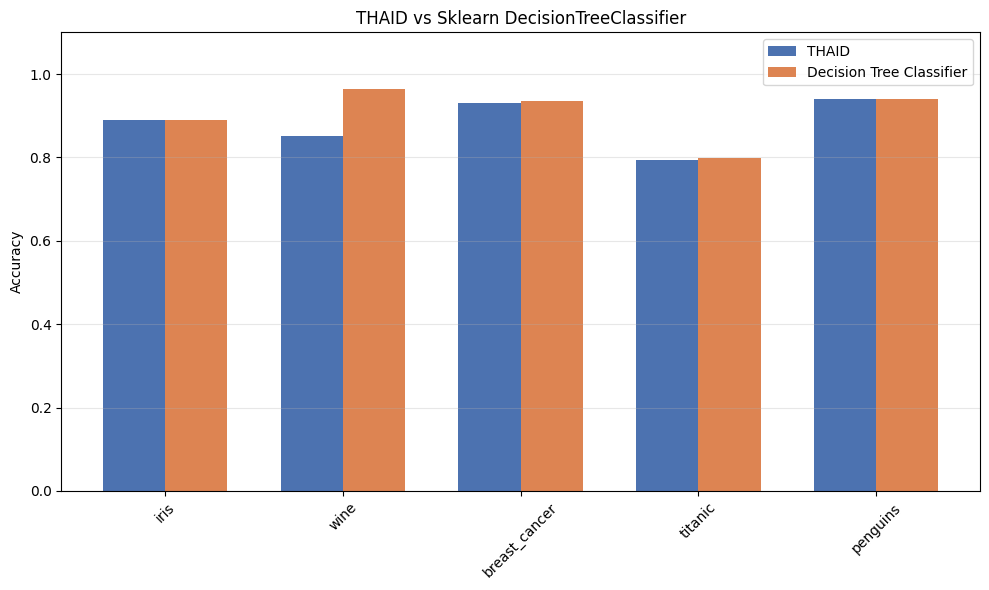

✓ Saved 'thaid_speed.png'


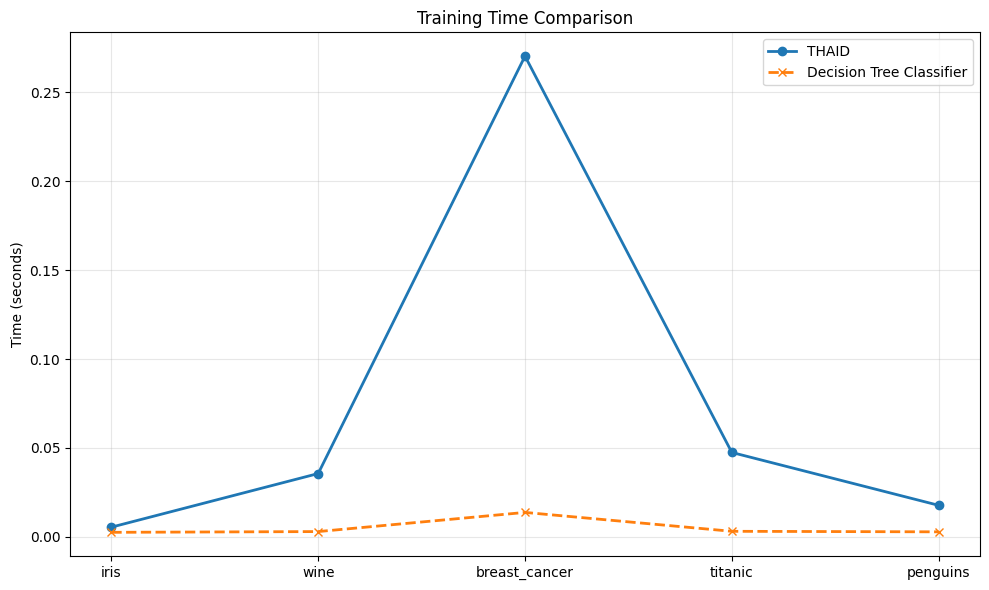


Tests Completed.


In [5]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris, load_wine, load_breast_cancer

# Ensure THAID is imported or defined
# from your_module import THAID

warnings.filterwarnings('ignore')

class THAIDTester:
    """Comprehensive testing for the THAID algorithm against real-world data."""

    def __init__(self, base_model_params=None):
        self.base_params = base_model_params if base_model_params else {
            'min_samples_split': 20,
            'min_samples_leaf': 1,
            'max_depth': None
        }
        self.results = {}

    def _get_fresh_model(self, **kwargs):
        params = self.base_params.copy()
        params.update(kwargs)
        # ASSUMPTION: THAID class is defined in your scope
        return THAID(**params)

    def load_datasets(self):
        print("Loading datasets...")
        datasets = {}

        # Iris
        iris = load_iris()
        datasets['iris'] = {
            'X': pd.DataFrame(iris.data, columns=iris.feature_names),
            'y': pd.Series(iris.target),
            'description': 'Iris (150 samples, 4 features, 3 classes)'
        }

        # Wine
        wine = load_wine()
        datasets['wine'] = {
            'X': pd.DataFrame(wine.data, columns=wine.feature_names),
            'y': pd.Series(wine.target),
            'description': 'Wine (178 samples, 13 features, 3 classes)'
        }

        # Breast Cancer
        cancer = load_breast_cancer()
        datasets['breast_cancer'] = {
            'X': pd.DataFrame(cancer.data, columns=cancer.feature_names),
            'y': pd.Series(cancer.target),
            'description': 'Breast Cancer (569 samples, 30 features, 2 classes)'
        }

        # Titanic
        try:
            titanic = sns.load_dataset('titanic')
            titanic = titanic[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'survived']].dropna()
            X_titanic = titanic.drop(columns=['survived'])
            y_titanic = titanic['survived']
            le = LabelEncoder()
            X_titanic['sex'] = le.fit_transform(X_titanic['sex'])
            X_titanic['embarked'] = le.fit_transform(X_titanic['embarked'])

            datasets['titanic'] = {
                'X': X_titanic,
                'y': y_titanic,
                'description': f'Titanic ({len(X_titanic)} samples, 7 features, 2 classes)'
            }
        except Exception:
            print("Warning: Could not load Titanic dataset")

        # Penguins
        try:
            penguins = sns.load_dataset('penguins').dropna()
            X_penguins = penguins.drop(columns=['species'])
            y_penguins = LabelEncoder().fit_transform(penguins['species'])
            le = LabelEncoder()
            X_penguins['sex'] = le.fit_transform(X_penguins['sex'])
            X_penguins['island'] = le.fit_transform(X_penguins['island'])

            datasets['penguins'] = {
                'X': X_penguins,
                'y': pd.Series(y_penguins),
                'description': f'Penguins ({len(X_penguins)} samples, 6 features, 3 classes)'
            }
        except Exception:
            print("Warning: Could not load Penguins dataset")

        print(f"✓ Loaded {len(datasets)} datasets successfully.")
        return datasets

    def test_basic_functionality(self, datasets):
        print("\n" + "="*60)
        print("1. BASIC FUNCTIONALITY TEST")
        print("="*60)
        results = {}

        for name, data in datasets.items():
            print(f"\ndataset: {name.upper()}")
            X_train, X_test, y_train, y_test = train_test_split(
                data['X'], data['y'], test_size=0.3, random_state=42, stratify=data['y']
            )

            try:
                model = self._get_fresh_model()
                t0 = time.time()
                model.fit(X_train, y_train)
                fit_time = time.time() - t0

                t0 = time.time()
                y_pred = model.predict(X_test)
                pred_time = time.time() - t0

                train_acc = model.score(X_train, y_train)
                test_acc = accuracy_score(y_test, y_pred)

                results[name] = {'train_acc': train_acc, 'test_acc': test_acc, 'fit_time': fit_time, 'success': True}
                print(f"  ✓ Train Acc: {train_acc:.4f}")
                print(f"  ✓ Test Acc:  {test_acc:.4f}")
                print(f"  ✓ Time:      {fit_time*1000:.2f}ms")
            except Exception as e:
                print(f"  ✗ FAILED: {str(e)}")
                results[name] = {'success': False}

        self.results['basic'] = results
        return results

    def test_cross_validation(self, datasets, cv=5):
        print("\n" + "="*60)
        print("2. CROSS-VALIDATION ROBUSTNESS")
        print("="*60)
        results = {}

        for name, data in datasets.items():
            print(f"\nDataset: {name.upper()}")
            try:
                skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
                scores = []
                X = data['X'].reset_index(drop=True)
                y = data['y'].reset_index(drop=True)

                for train_idx, val_idx in skf.split(X, y):
                    model = self._get_fresh_model()
                    model.fit(X.iloc[train_idx], y.iloc[train_idx])
                    scores.append(model.score(X.iloc[val_idx], y.iloc[val_idx]))

                results[name] = {'mean': np.mean(scores), 'std': np.std(scores), 'success': True}
                print(f"  ✓ Mean Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
            except Exception as e:
                print(f"  ✗ FAILED: {str(e)}")
                results[name] = {'success': False}

        self.results['cv'] = results
        return results

    def test_comparison_sklearn(self, datasets):
        """Benchmark against Scikit-Learn's DecisionTreeClassifier."""
        print("\n" + "="*60)
        print("3. BENCHMARK VS SKLEARN DecisionTreeClassifier")
        print("="*60)

        results = {}

        for name, data in datasets.items():
            print(f"\nDataset: {name.upper()}")
            X_train, X_test, y_train, y_test = train_test_split(
                data['X'], data['y'], test_size=0.3, random_state=42, stratify=data['y']
            )

            try:
                # 1. THAID
                thaid = self._get_fresh_model()
                t0 = time.time()
                thaid.fit(X_train, y_train)
                t_thaid = time.time() - t0
                acc_thaid = thaid.score(X_test, y_test)

                # 2. Sklearn DecisionTreeClassifier
                sk_tree = DecisionTreeClassifier(
                    min_samples_split=self.base_params['min_samples_split'],
                    min_samples_leaf=self.base_params['min_samples_leaf'],
                    max_depth=self.base_params['max_depth'],
                    random_state=42
                )
                t0 = time.time()
                sk_tree.fit(X_train, y_train)
                t_sk = time.time() - t0
                acc_sk = sk_tree.score(X_test, y_test)

                diff = acc_thaid - acc_sk

                results[name] = {
                    'thaid_acc': acc_thaid,
                    'sk_acc': acc_sk,
                    'thaid_time': t_thaid,
                    'sk_time': t_sk,
                    'success': True
                }

                print(f"  THAID Accuracy:         {acc_thaid:.4f} ({t_thaid*1000:.2f}ms)")
                print(f"  Sklearn DTC Accuracy:   {acc_sk:.4f} ({t_sk*1000:.2f}ms)")
                print(f"  Difference:             {diff:+.4f}")

            except Exception as e:
                print(f"  ✗ FAILED: {str(e)}")

        self.results['benchmark'] = results
        return results

    def generate_visualizations(self, show_plots=True, save_plots=True):
        if not self.results:
            return

        print("\n" + "="*60)
        print("GENERATING PLOTS...")
        print("="*60)

        # 1. Benchmark Plot
        if 'benchmark' in self.results:
            data = self.results['benchmark']
            names = [k for k in data.keys() if data[k].get('success')]

            if names:
                thaid_scores = [data[k]['thaid_acc'] for k in names]
                sk_scores = [data[k]['sk_acc'] for k in names]

                x = np.arange(len(names))
                width = 0.35

                plt.figure(figsize=(10, 6))
                plt.bar(x - width/2, thaid_scores, width, label='THAID', color='#4c72b0')
                # RENAMED LABEL HERE
                plt.bar(x + width/2, sk_scores, width, label='Decision Tree Classifier', color='#dd8452')

                plt.ylabel('Accuracy')
                plt.title('THAID vs Sklearn DecisionTreeClassifier')
                plt.xticks(x, names, rotation=45)
                plt.ylim(0, 1.1)
                plt.legend()
                plt.grid(axis='y', alpha=0.3)
                plt.tight_layout()

                if save_plots:
                    plt.savefig('thaid_benchmark.png')
                    print("✓ Saved 'thaid_benchmark.png'")

                if show_plots:
                    plt.show()
                else:
                    plt.close()

        # 2. Fit Time Comparison
        if 'benchmark' in self.results:
            data = self.results['benchmark']
            names = [k for k in data.keys() if data[k].get('success')]

            if names:
                thaid_time = [data[k]['thaid_time'] for k in names]
                sk_time = [data[k]['sk_time'] for k in names]

                plt.figure(figsize=(10, 6))
                plt.plot(names, thaid_time, marker='o', label='THAID', linewidth=2)
                # RENAMED LABEL HERE
                plt.plot(names, sk_time, marker='x', label='Decision Tree Classifier', linewidth=2, linestyle='--')

                plt.ylabel('Time (seconds)')
                plt.title('Training Time Comparison')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()

                if save_plots:
                    plt.savefig('thaid_speed.png')
                    print("✓ Saved 'thaid_speed.png'")

                if show_plots:
                    plt.show()
                else:
                    plt.close()

def run_tests():
    tester = THAIDTester(base_model_params={
        'min_samples_split': 20,
        'min_samples_leaf': 5,
        'max_depth': 6
    })
    datasets = tester.load_datasets()
    tester.test_basic_functionality(datasets)
    tester.test_cross_validation(datasets)
    tester.test_comparison_sklearn(datasets)
    tester.generate_visualizations(show_plots=True, save_plots=True)
    print("\nTests Completed.")

if __name__ == "__main__":
    run_tests()